<a href="https://colab.research.google.com/github/SergiuMaier/Hand_Gesture_Recognition/blob/main/Hand_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition dataset'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)

# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)

# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['dataset', 'model.pth', 'model_antrenat.pth']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_transform=transforms.Compose([
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
train_dir = '/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition dataset/dataset/train/train'
test_dir = '/content/gdrive/MyDrive/Colab Notebooks/Hand Gesture Recognition dataset/dataset/test/test'

In [ ]:
dataset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
labels = dataset.classes

test_classes_dict = {v: k for k, v in testset.class_to_idx.items()}
print(test_classes_dict)

{0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9'}


In [ ]:
torch.manual_seed(10)

val_size = len(dataset)//5
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset

len(train_ds), len(val_ds), len(test_ds)

(14440, 3610, 6010)

In [ ]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

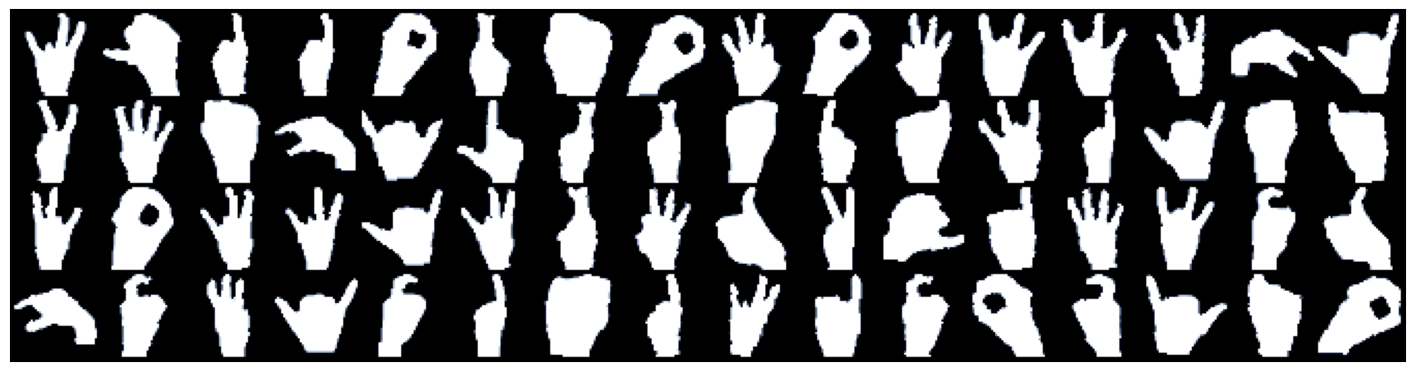

In [ ]:
for images, labels in train_loader:
    # Rescale pixel values to [0, 1]
    images = images / 2 + 0.5
    images = np.clip(images, 0, 1)

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))

    break

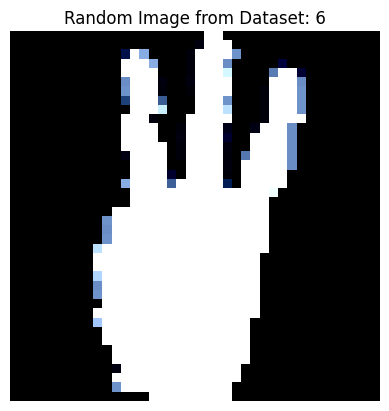

In [ ]:
def random_image(dataset):
    # Obține o imagine aleatorie și eticheta asociată
    random_index = random.randint(0, len(dataset) - 1)
    image, label = dataset[random_index]

    # Afișează imaginea și eticheta
    plt.imshow(image.permute(1,2,0))
    plt.title('Random Image from Dataset: '+ dataset.classes[label])
    plt.axis('off')
    plt.show()

random_image(dataset)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    history = []  # List to store training history
    optimizer = opt_func(model.parameters(), lr)  # Initialize optimizer

    for epoch in range(epochs):
        # Training Phase
        model.train()  # Set model to training mode
        train_losses = []  # List to store training losses

        for batch in tqdm(train_loader):
            loss = model.training_step(batch)  # Compute loss for the current batch
            train_losses.append(loss)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            optimizer.zero_grad()  # Clear gradients for the next iteration

        # Validation Phase
        result = evaluate(model, val_loader)  # Evaluate model on validation set
        result['train_loss'] = torch.stack(train_losses).mean().item()  # Compute mean training loss
        model.epoch_end(epoch, result)  # Perform any end-of-epoch operations in the model
        history.append(result)  # Append current epoch's result to the history

    return history

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(6250, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(labels)))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model.load_state_dict(torch.load('model_antrenat.pth'))

#model = to_device(CnnModel(), device)

<All keys matched successfully>

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

In [ ]:
history = [evaluate(model, val_loader)]
print(history)

[{'val_loss': 3.003679037094116,
  'val_acc': 0.050087038427591324,
  'train_acc': 0.04889380559325218}]

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_losses():
    train_loss_values = [1.6680, 0.8979, 0.1036, 0.0704, 0.0247, 0.0290, 0.0329, 0.0221, 0.0368, 0.0553]
    val_loss_values = [3.0068, 0.1333, 0.1374, 0.0313, 0.0254, 0.0224, 0.0110, 0.0554, 0.0063, 0.0165]
    epochs = range(1, len(train_loss_values) + 1)

    plt.plot(epochs, train_loss_values, '-x', label='Training Loss')
    plt.plot(epochs, val_loss_values, '-x', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_accuracies():
    train_acc_values = [0.0499, 0.7073, 0.9688, 0.9808, 0.9934, 0.9927, 0.9901, 0.9943, 0.9911, 0.9896]
    val_acc_values = [0.0468, 0.9642, 0.9725, 0.9927, 0.9938, 0.9943, 0.9962, 0.9860, 0.9981, 0.9968]
    epochs = range(1, len(train_acc_values) + 1)

    plt.plot(epochs, train_acc_values, '-x', label='Training Accuracy')
    plt.plot(epochs, val_acc_values, '-x', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

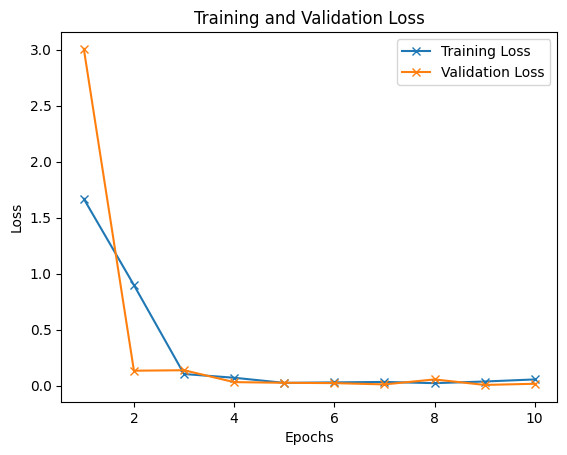

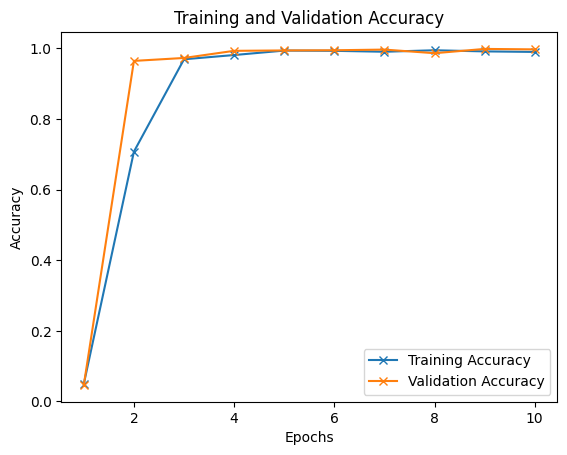

In [ ]:
plot_losses()
plot_accuracies()

In [ ]:
torch.save(model.state_dict(), 'model_antrenat.pth')

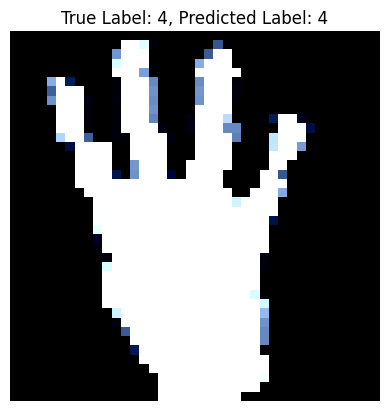

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Select a random index from the test set
random_image = random.randint(0, len(testset)-1)

# Get the image and true label
image, true_label_idx = testset[random_image]
true_label = test_classes_dict[true_label_idx]

# Prepare the image for testing
input_tensor = image.unsqueeze(0).to(device)

# Perform the prediction on the selected image
with torch.no_grad():
    output = model(input_tensor)
    predicted_label_idx = torch.argmax(output, dim=1)
    predicted_label = test_classes_dict[predicted_label_idx.item()]

# Display the results
plt.imshow(image.permute(1, 2, 0))
plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()